## Quantify similarity/divergence of human vs model=f(prompt)

Goal of Waerme und Wohnen Panel: understand the drivers and constraints for renovations to increase energy efficiency in Germany per socio-economic/demographic profile 
Goal of the thesis research: 
1. Reproduce hunan drivers/constraints for renovations in order to use the method for potential future pilot studies
2. If not possible to reproduce results identify and quantify the biases as well as potential solutions

### 1. Evaluate model decisions

The method aims to support pilot studies for policy design in the field of building decarbonization. 
From the three market failures presented in Singhal 2023:
* Externalities
    * What is the effect of internalizing the externality of CO2 emissions by carbon prices?
    * What is the effect of high volatility fossil fuel prices (high risk)
* Principal-Agent probelm
    * What is the effect of tenant/owner distribution of externalities and renovation costs
* **Credit Constraints**
    * **From those receiving subsidies, who are free raiders?** --> Always choose option B
    * **From those that do not perform a renovation, is it a budget constraint blocker? Who are them?** 
        * Hard limitations: Those that would only make the decision of complex renovation until 200 euros difference with simple (option 5)
        * Middle limitations: Those that would make the decision of complex renovation from 250-450 euros difference with simple (option 6-10) 
        * Mild limitations: Those that would make the decision of complex renovation from 500-900 euros difference with simple (option 11-14) 
    * What kind of errors will have a high penalty in policy design?
        * Consider free-raiders as price elastic citizens --> Diminish free-raider false negatives (recall): those that are predicted as something else but are free raiders so will get funding when they should not
        * Consider price elastic citizens as never-takers --> Diminish never-takers false negatives (recall): those that are predicted as compliers when are never-takers so have access to funding that wont be used

### 2. Quantify Bias
1. Do the models reproduce the human decisions? NO
    * Confusion matrix metrics
2. Which factors explain the error?
    * Option A) Fit a log regression with relevant factors to understand what drives decisions in humans vs model=f(prompt)
    * Option B) Model the error difference between the human and GPT-4
    * Option C) Model the difference between the decision taken and the rational decision according to object financial benefits
        * Calculate the optimal decision according to a) costs of renovation, b) savings per renovation and c) the expected years living in the flat
        * Compare bias/error from rational decion between human and GPT-4
        * Compare bias/error between different GPT-4 prompts (and GPT-3.5)
3. Is the error different depending on the type of prompt or is it consistent so it depends on the model?
4. Is the error symmetric or asymmetric?

**Which kind of information do I need for option C?**
* Option C) What determines if a person makes rational or emotional decisions?
    * Education level --> affect the next ones
    * Life ownership
    * Nature conservation concern
    * Belief in energy efficiency
    * Political orientation
    * Income and wealth level --> affect the next one
    * Long-term profit oriented
* Option C) How do I define rational behavior?
    * The savings in energy over the planned years (case -2% price increase or worse case scenario) - renovation costs ==> Highest profit option at each question
    * Market value variation --> purchase according to the DIW study 
    * Fix values per individual
        * savings per renovation type x years in the house
        * market value variation per renovation type
        * renovation costs of simple renovation
    * Variable values per individual
        * Net Present Value (PAPER MIT) = Gain Market Value + savings=f(discount rate, years) - Renovation Costs
        * Gain Market Value (DIW report) =  β × (EPSoriginal − EPS) where β = 0.71 EUR/m2 for purchasing and 0.002 EUR/m2 for renting
    * Calculate rational decision according to the previous calculations
        * Keep the information of difference on NPV
        * Keep the information of difference on Renovation costs
        * Keep the information of where the transition between complex and simple should happen, if at all, from a rational perspective
        * Keep the information of where the transition between complex and simple happen, if at all, by the human and the algorithm
        * Calculate where should be the transition from complex to simple if any to maximize NPV in each decision
    * Regression on the decision
        * Quantify the difference between the optimal rational transition, if any, and the human/algorithm
            * Difference in NPV
            * Difference in renovation cost
        * Every decision could be attributed the 0/1 value for matching rational decision or not --> does not capture asymmetric behavior
        * Every decision could be attributed the actual difference on NPV between the rational option and the decision made --> does capture asymmetric behavior
            * Requires panel data analysis
        * One decision per individual rather than per question --> Difference between the optimal transition point by rational agent vs human/algorithm in terms of NPV diff
            * Does not require panel data analysis
        * Factors
            * Prostpect theory: loss adversion/risk preference
                * Long term benefit
                * Life handling
                * Altruism
                * Beliefs on energy efficiency
            * Socioeconomic factors
                * Political orientation
                * Income level/wealth level
                * Education level
                * Building type

In [23]:
import sys
import ast
sys.path.append("../../../")

import numpy as np
import pandas as pd

from scipy.stats import norm

from src.eval_utils.metric_calculator import ResultEvaluator, plot_class_recalls, plot_recall
from src.eval_utils.utility_calculator import DeltaNVP

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load results

In [18]:
final_columns = ['ea801', 'ea802', 'ea803', 'ea804', 'ea805', 'ea806', 'ea807', 'ea808', 'ea809', 'ea810', 'ea811', 
                 'ea812', 'ea813', 'ea814', 'ea815']
opportunity_cost = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 900, 1200]
# Generate dataframe for evaluation
socioeconomic_factors = ['total_income_level','is_high_wealth','high_education_level','altq','prof_status']
psychological_factors = ['pol_orientation','is_altruist','nature_level','ownership_level','profit_focus','ee_belief']
npv_factors = ['ist5','kdj','kde','kdu','ebj','ebe','ebu','a6']
columns_to_exclude_ols = ['success', 'label', 'temperature', 'decision', 'key', 
                      'citizen_type', 'profit_focus_long', 'profit_focus_short', 
                      'ownership_level_Medium', 'ownership_level_High', 
                      'nature_level_High', 'nature_level_Medium', 
                      'pol_orientation_left', 'pol_orientation_right', 
                      'pol_orientation_center', 'is_altruist']

df_sample = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_completed_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')
df_questions = pd.read_csv("../../../data/ariadne/heating_buildings/questions_selected_survey_mapper_encoded.csv", sep=';', encoding='utf-8', on_bad_lines='skip')
df_sel_complete_pol_ta_clean = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_sample_100_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')

output_file0 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1030/length_gpt-3.5-turbo-1106-t_0.1_nq_0_qa.csv'
output_file3 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1041/length_gpt-3.5-turbo-1106-t_0.1_nq_3_qa.csv'
output_file5 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1049/length_gpt-3.5-turbo-1106-t_0.1_nq_5_qa.csv'
output_file7 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1057/length_gpt-3.5-turbo-1106-t_0.1_nq_7_qa.csv'
output_file9 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1110/length_gpt-3.5-turbo-1106-t_0.1_nq_9_qa.csv'
output_file12 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1119/length_gpt-3.5-turbo-1106-t_0.1_nq_12_qa.csv'
output_file15 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1130/length_gpt-3.5-turbo-1106-t_0.1_nq_15_qa.csv'
df_synthetic_samples0 = pd.read_csv(output_file0)
df_synthetic_samples3 = pd.read_csv(output_file3)
df_synthetic_samples5 = pd.read_csv(output_file5)
df_synthetic_samples7 = pd.read_csv(output_file7)
df_synthetic_samples9 = pd.read_csv(output_file9)
df_synthetic_samples12 = pd.read_csv(output_file12)
df_synthetic_samples15 = pd.read_csv(output_file15)

output_file_liter = '../../../data/ariadne/heating_buildings/experiment_1/20240109_0104/length_gpt-3.5-turbo-1106-t_0.1_nq_15_qa.csv'
df_synthetic_samples_liter = pd.read_csv(output_file_liter)
output_file_reg = '../../../data/ariadne/heating_buildings/experiment_1/20240109_0129/length_gpt-3.5-turbo-1106-t_0.1_nq_15_qa.csv'
df_synthetic_samples_reg = pd.read_csv(output_file_reg)

### 2. Calculate model performance by prompt strategy and temperature

#### 2.1. Calculate confusion matrices

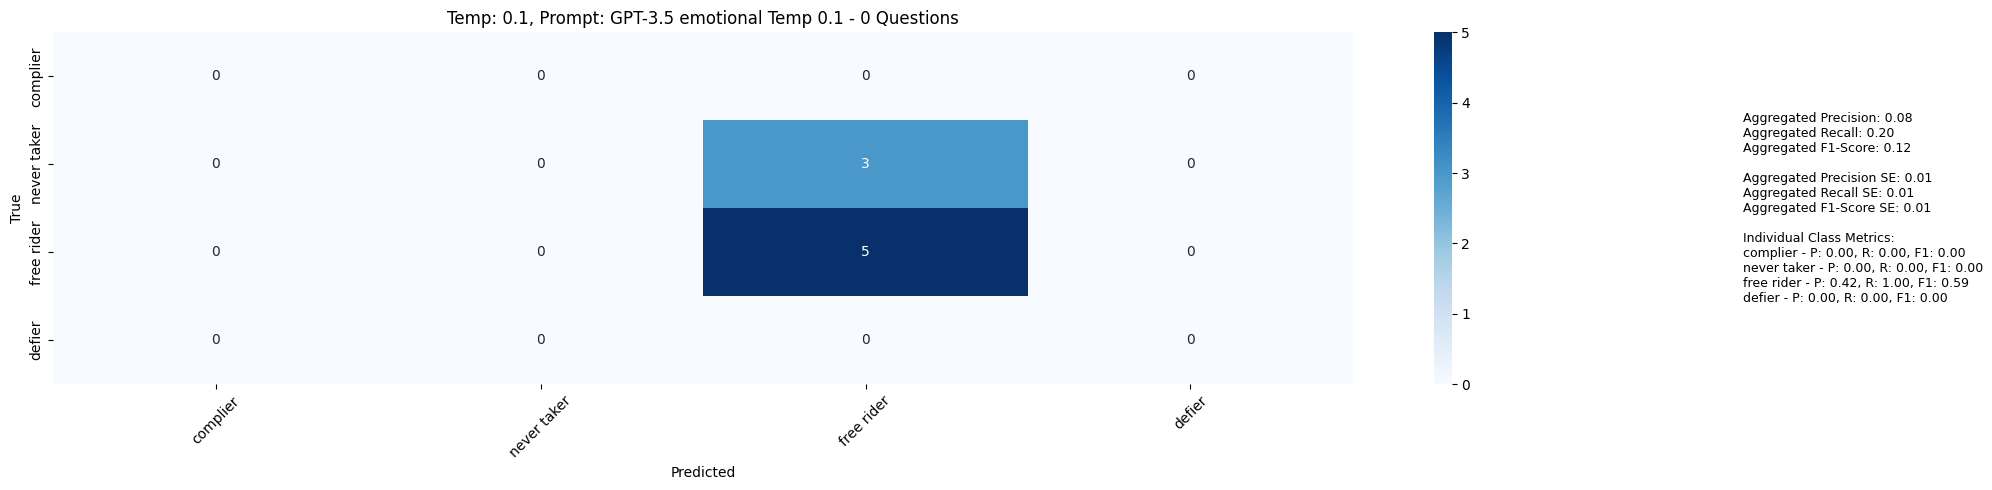

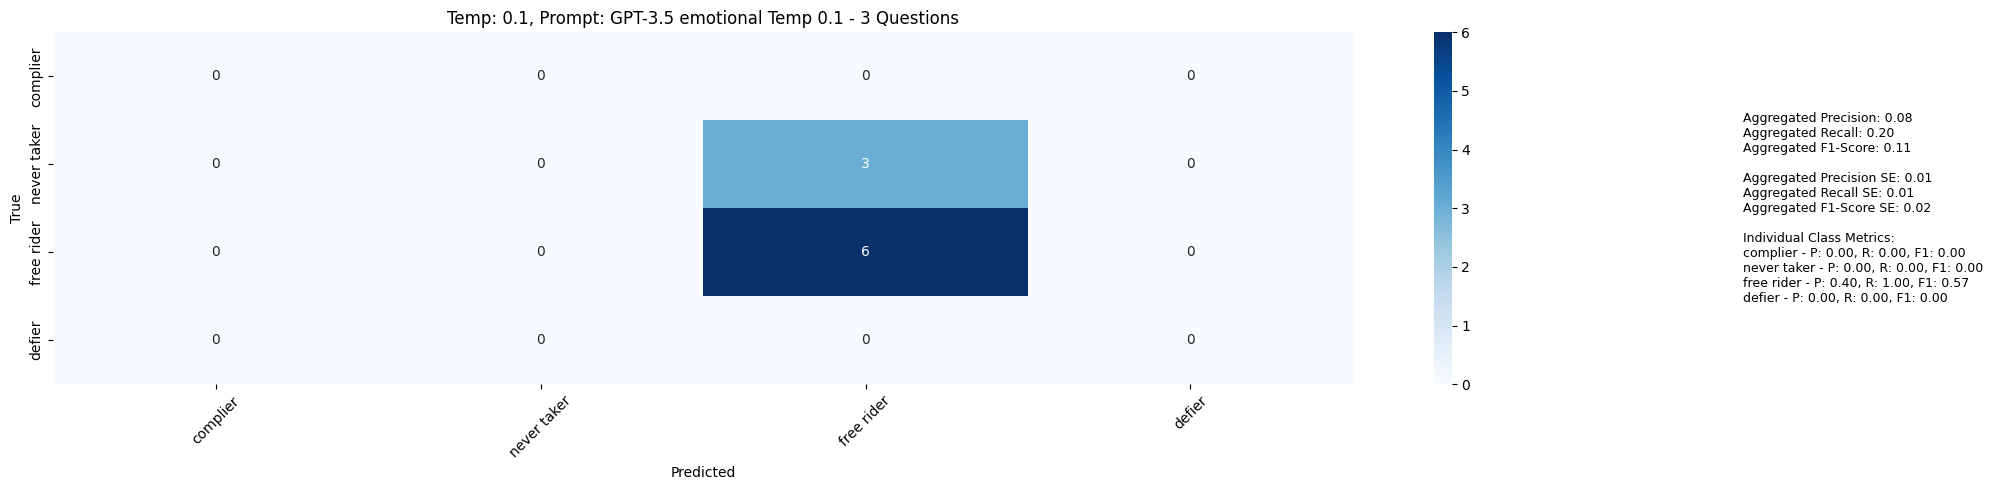

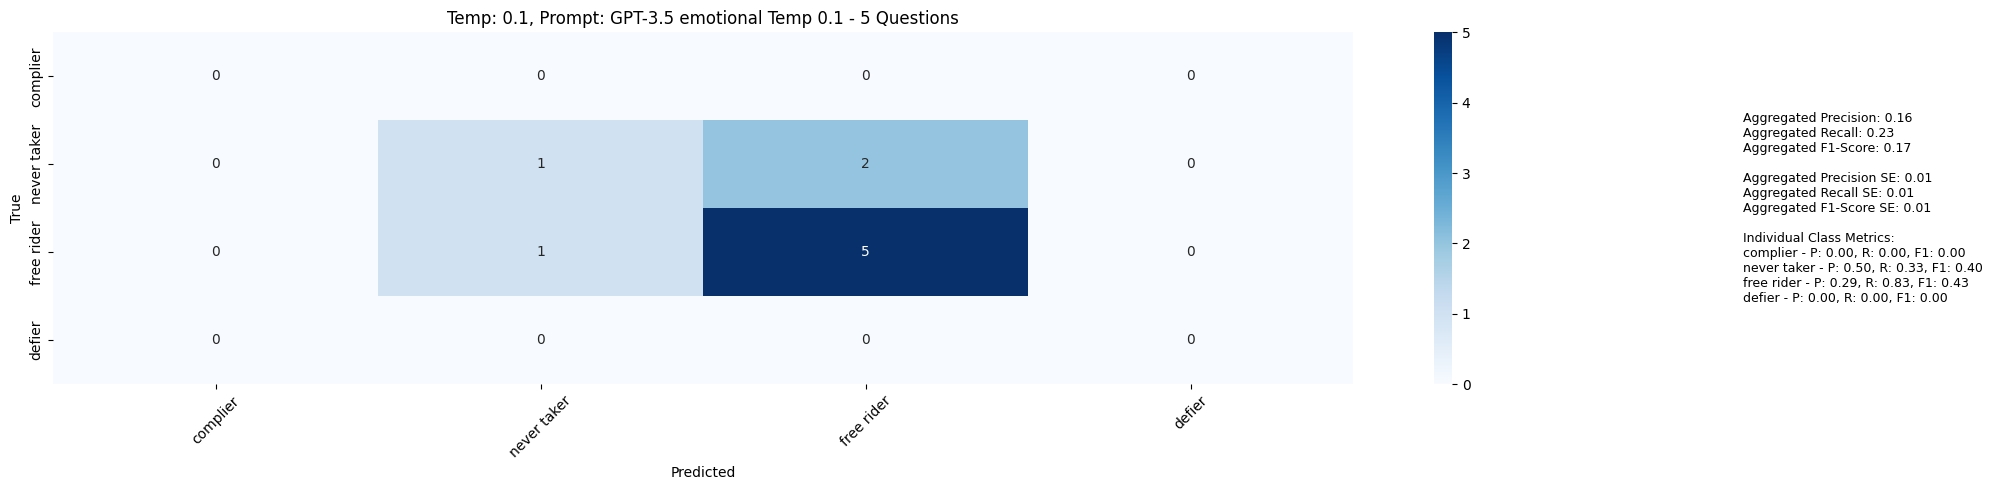

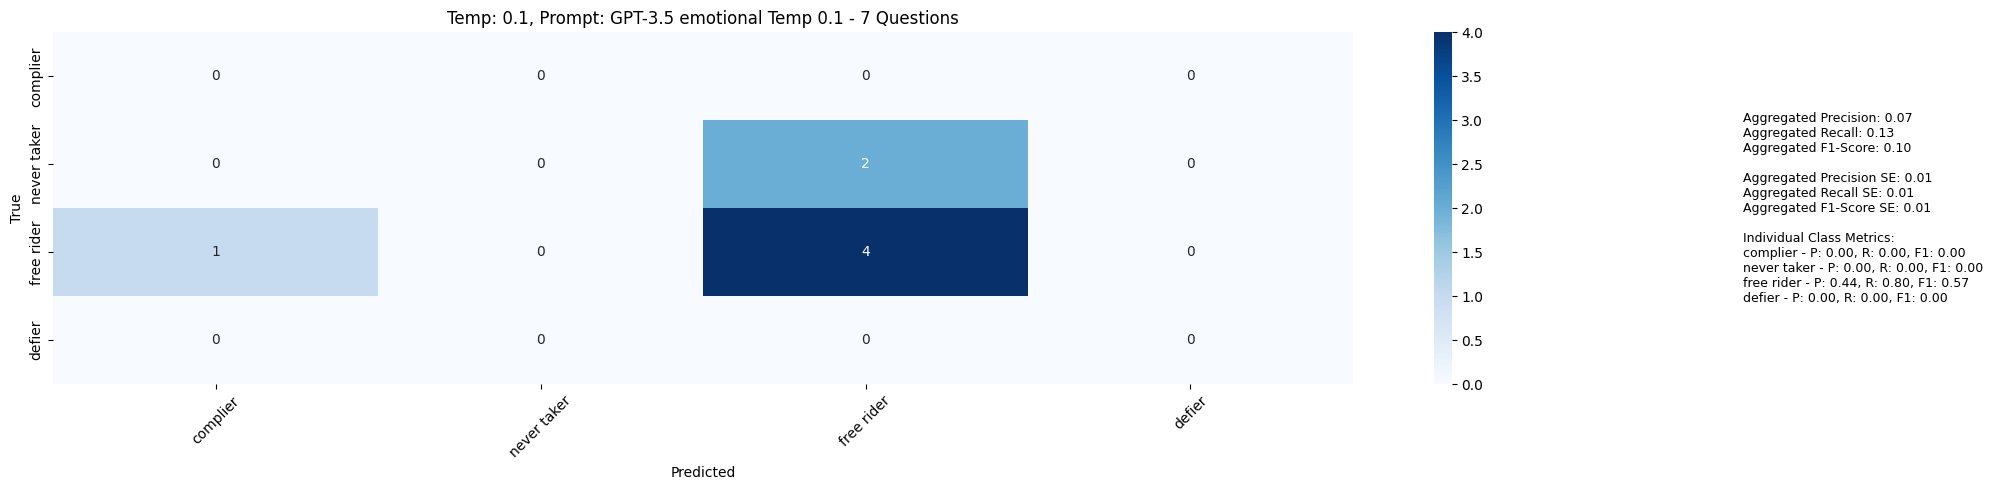

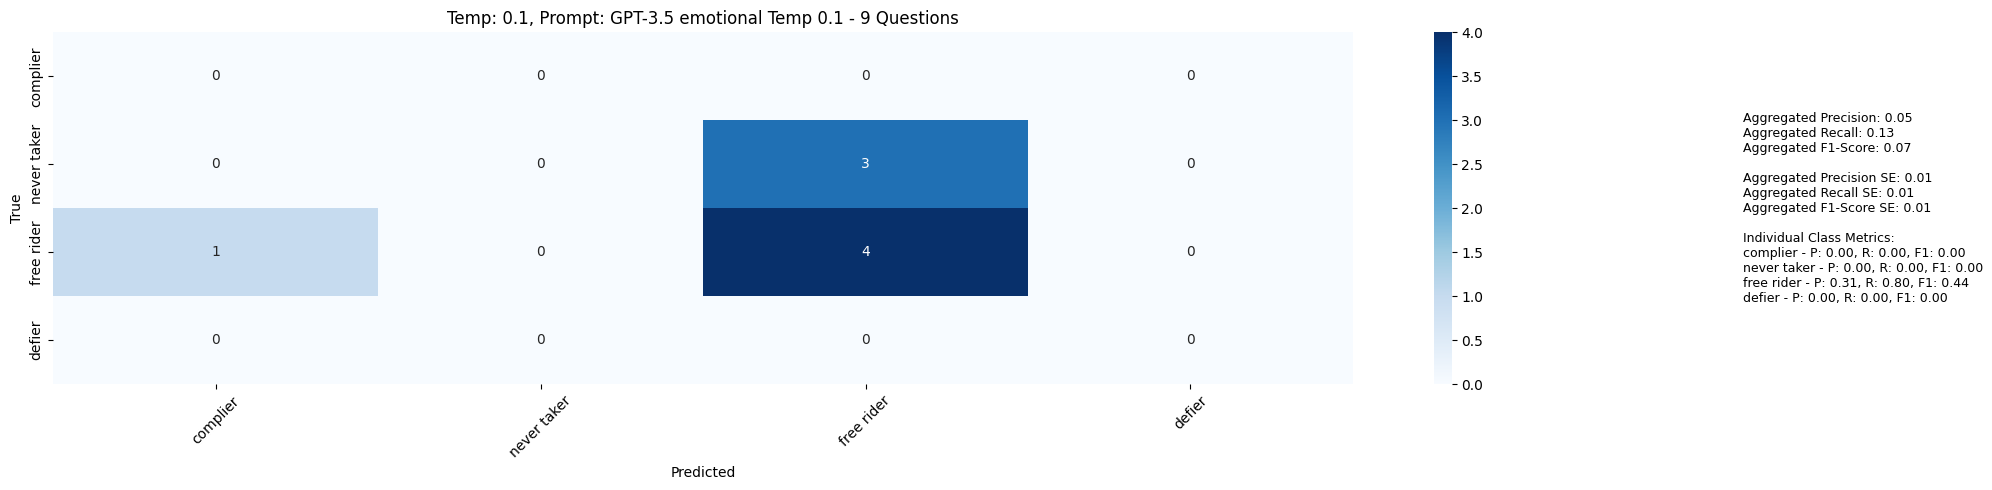

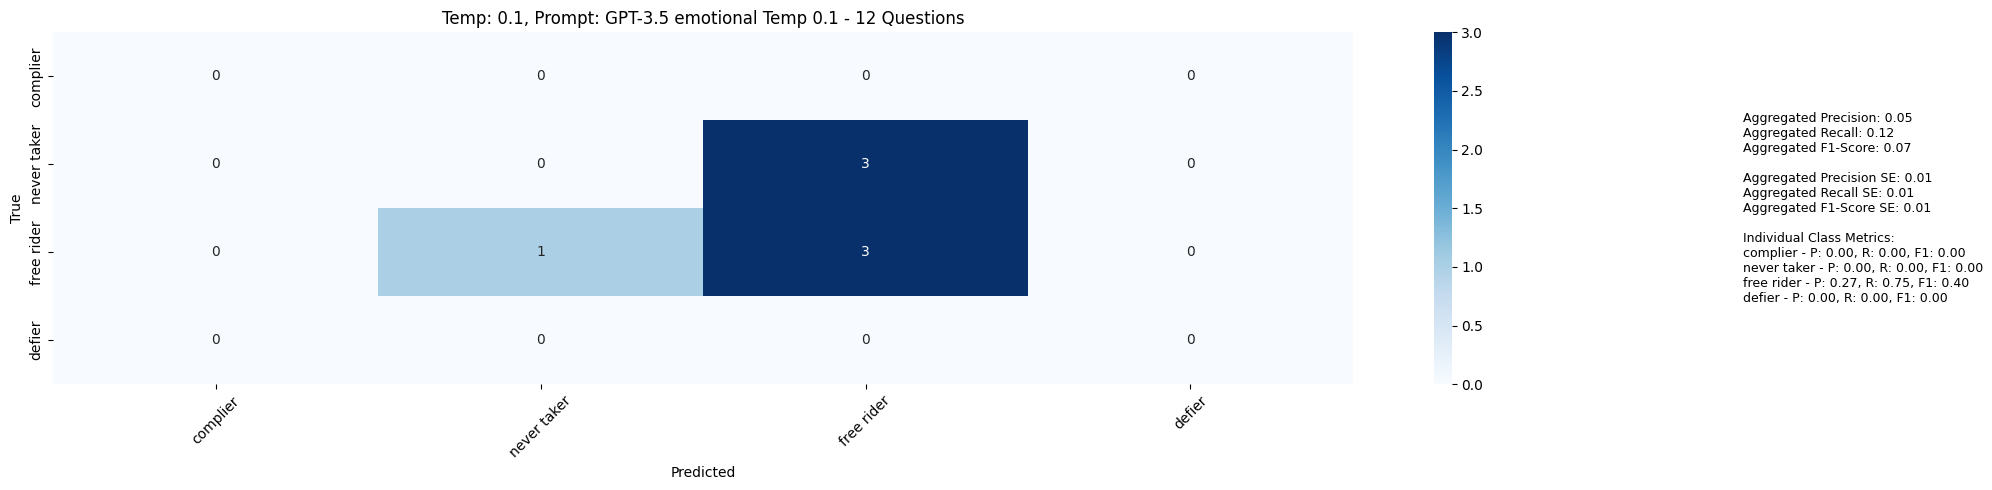

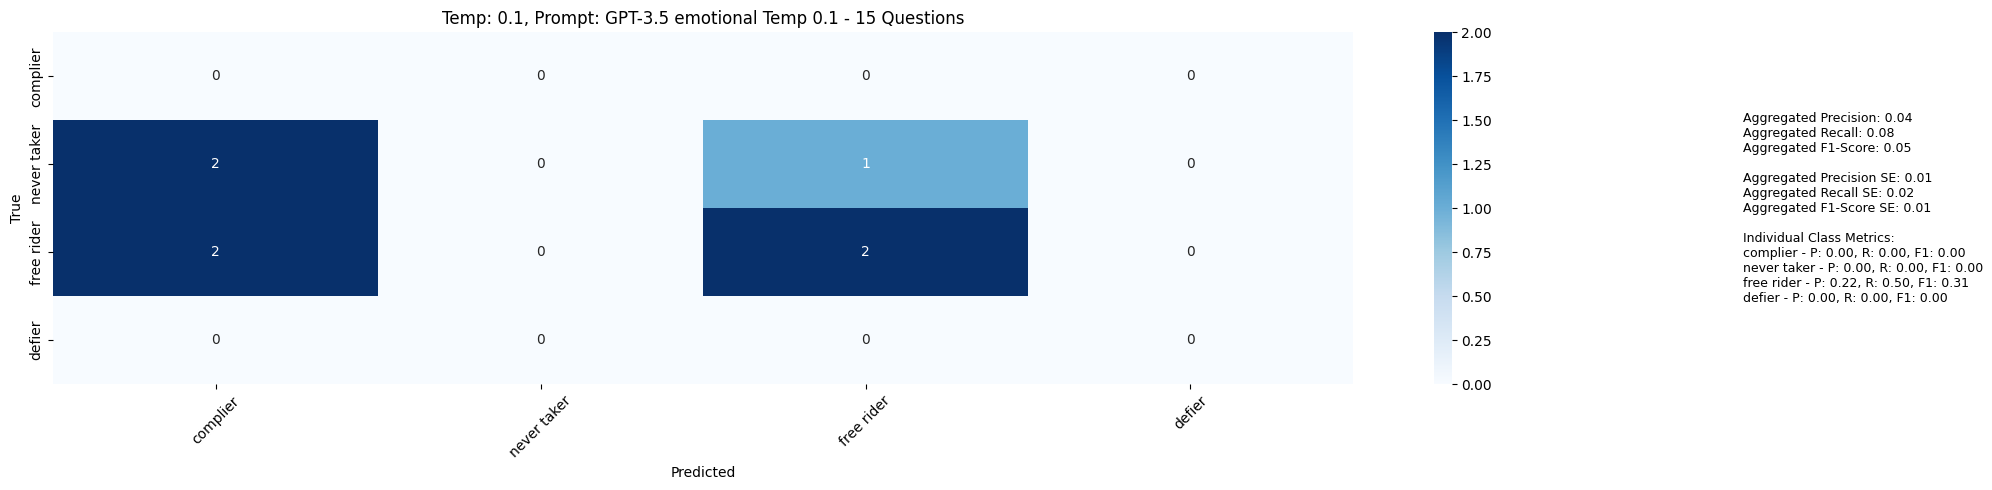

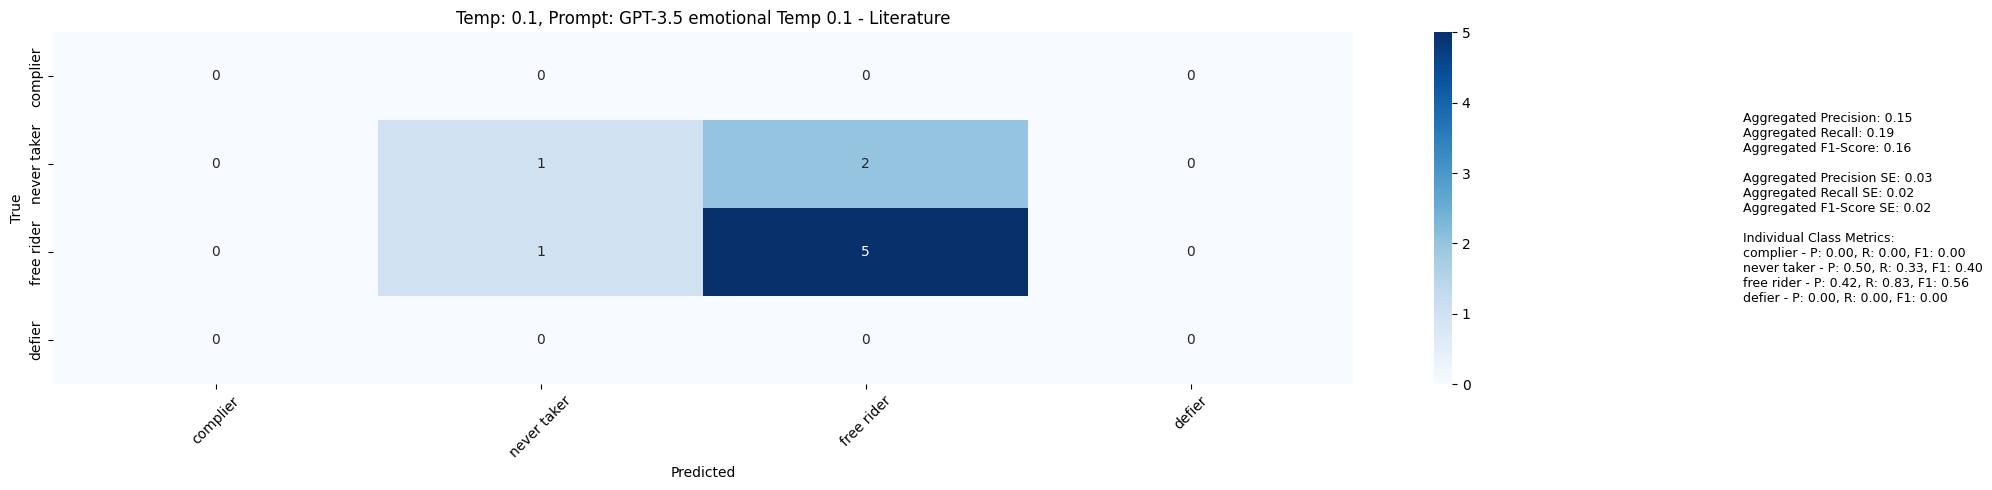

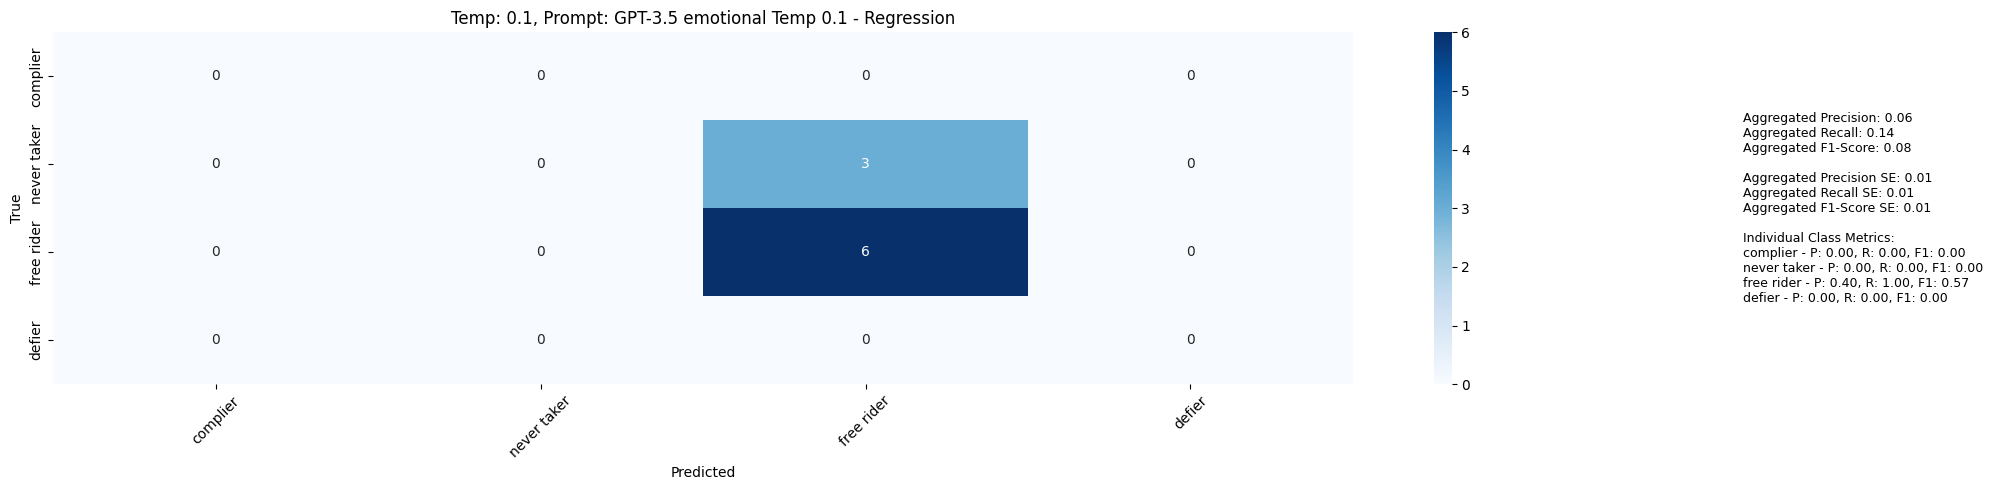

In [19]:
metrics = []
n_bootstraps = 5
evaluator = ResultEvaluator(final_columns=final_columns, opportunity_costs=opportunity_cost)

# First set of metrics collection
df_metrics, df_sample_sel_0_emotional, df_synthetic_0_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples0], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 0 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

# Update the remaining calls with the appropriate dataframe names
df_metrics, df_sample_sel_3_emotional, df_synthetic_3_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples3], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 3 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_5_emotional, df_synthetic_5_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples5], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 5 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_7_emotional, df_synthetic_7_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples7], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 7 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_9_emotional, df_synthetic_9_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples9], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 9 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_12_emotional, df_synthetic_12_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples12], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 12 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_15_emotional, df_synthetic_15_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples15], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - 15 Questions', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_sel_liter_emotional, df_synthetic_liter_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples_liter], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - Literature', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

df_metrics, df_sample_reg_emotional, df_synthetic_reg_emotional = evaluator.collect_metrics_across_conditions(
    df_sample, [df_synthetic_samples_reg], 
    ['complier','never taker', 'free rider','defier'], 
    [0.1], 'GPT-3.5 emotional Temp 0.1 - Regression', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)



#### 2.1. Calculate bootstrapped recall for key classes

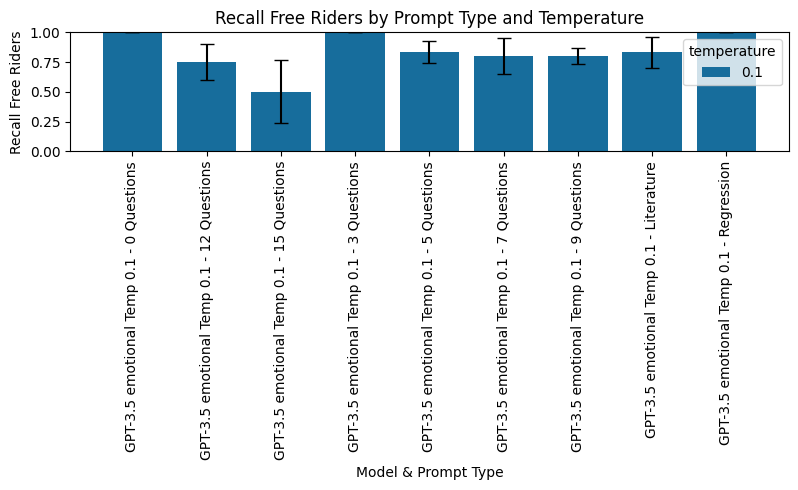

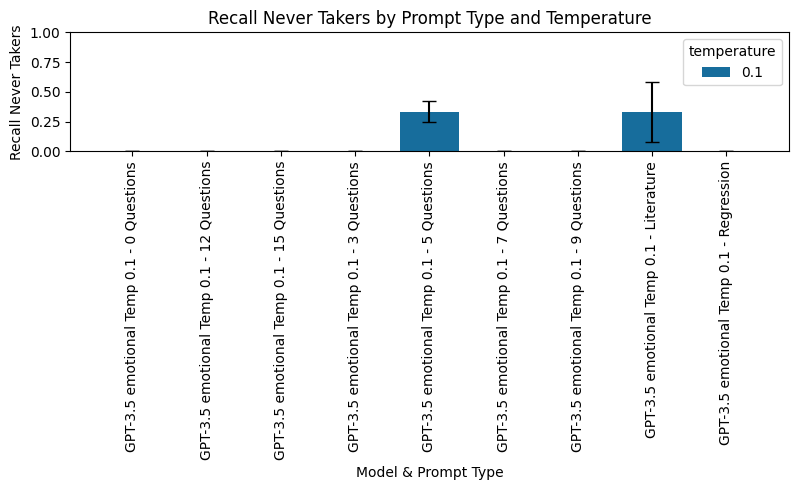

In [20]:
df_metrics = pd.concat(metrics)
df_ = plot_class_recalls(df_metrics)
plot_recall(df_, recall_type='recall_free_riders')
plot_recall(df_, recall_type='recall_never_takers')

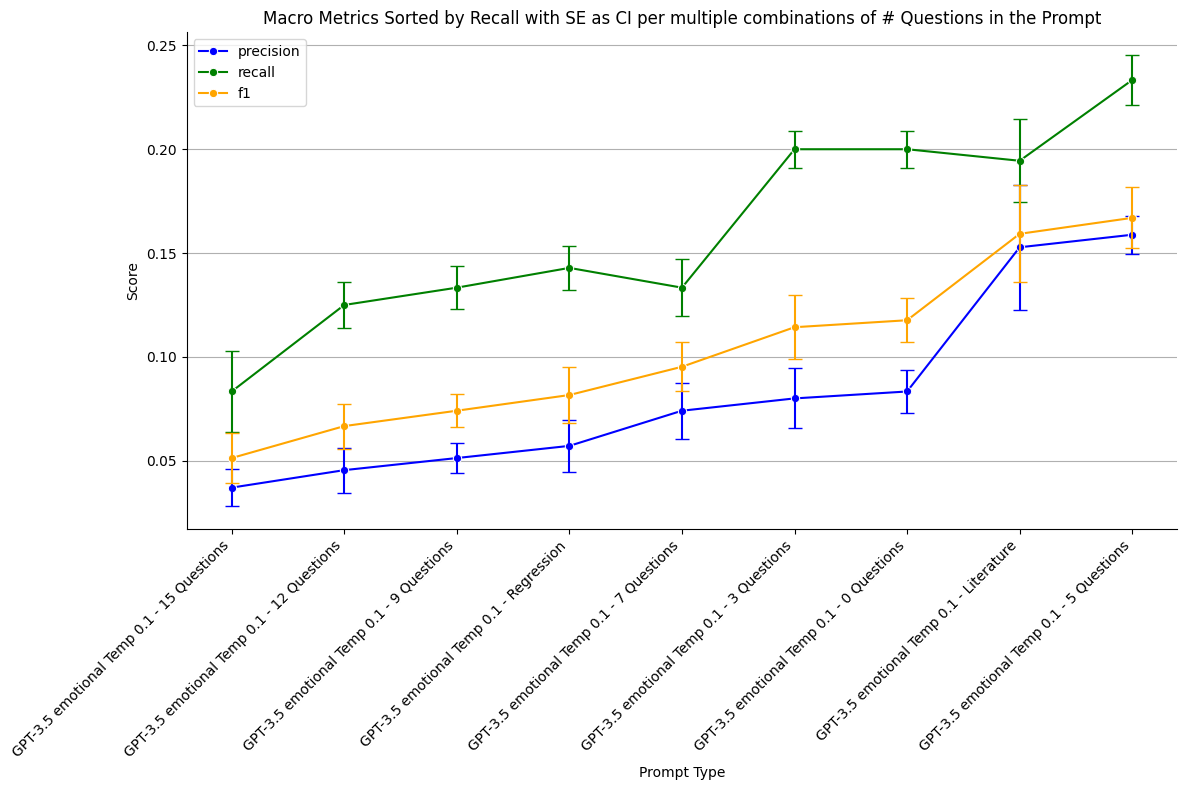

In [31]:
# Sort the DataFrame based on 'precision_agg' from lowest to highest
df_sorted = df_.sort_values('precision_agg')

# Plotting using seaborn lineplot
plt.figure(figsize=(12, 8))

# Define colors for each metric line
colors = ['blue', 'green', 'orange']

# Plot each metric line and add error bars
for i, metric in enumerate(['precision_agg', 'recall_agg', 'f1_score_agg']):
    # Extract the corresponding standard error column name
    se_column = f"{metric}_se"
    line = sns.lineplot(
        data=df_sorted, 
        x='prompt_type', 
        y=metric, 
        marker='o',  # Use circles as markers
        label=metric.split('_')[0],  # Get the label as the first part before '_'
        color=colors[i],  # Use the color defined in the list
        ci=None  # We will add error bars manually
    )
    # Get error bars values
    error = df_sorted[se_column]
    # Get the x values for the line plot
    x_values = df_sorted['prompt_type']
    # Plot the error bars
    plt.errorbar(
        x=x_values, 
        y=df_sorted[metric], 
        yerr=error, 
        fmt='none', 
        capsize=5, 
        ecolor=colors[i],  # Use the same color for error bars
        label='_nolegend_'  # Hide error bars from legend
    )

plt.title('Macro Metrics Sorted by Recall with SE as CI per multiple combinations of # Questions in the Prompt')
plt.xlabel('Prompt Type')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.legend()
plt.grid(axis='y')

# Improve the aesthetics for publication
sns.despine()  # Remove the top and right spines
plt.tight_layout()

# Show the plot
plt.show()